In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention, _ = self.attention(value, key, query, attn_mask=mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Transformer(nn.Module):
    def __init__(self, embed_size, heads, num_layers, dropout, forward_expansion):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size, heads, dropout, forward_expansion
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, value, key, query, mask):
        for layer in self.layers:
            query = layer(value, key, query, mask)
        return query


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_size, heads, num_layers, dropout, forward_expansion, latent_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_size)
        self.transformer = Transformer(embed_size, heads, num_layers, dropout, forward_expansion)
        self.fc_mu = nn.Linear(embed_size, latent_dim)
        self.fc_logvar = nn.Linear(embed_size, latent_dim)

    # def forward(self, x, mask=None):
    #     x = self.embedding(x)
    #     x = self.transformer(x, x, x, mask)
    #     mu = self.fc_mu(x)
    #     log_var = self.fc_logvar(x)
    #     return mu, log_var
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence length dimension
        x = self.transformer(x, x, x, mask)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, embed_size, heads, num_layers, dropout, forward_expansion, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, embed_size)
        self.transformer = Transformer(embed_size, heads, num_layers, dropout, forward_expansion)
        self.out = nn.Linear(embed_size, output_dim)

    def forward(self, x, mask=None):
        x = self.fc(x)
        x = self.transformer(x, x, x, mask)
        return self.out(x)



Epoch: 1/27 | Loss: 179.8343048 = Recon: 179.5054932 + KL: 3.2881300: 100%|██████████| 906/906 [00:36<00:00, 25.13it/s]


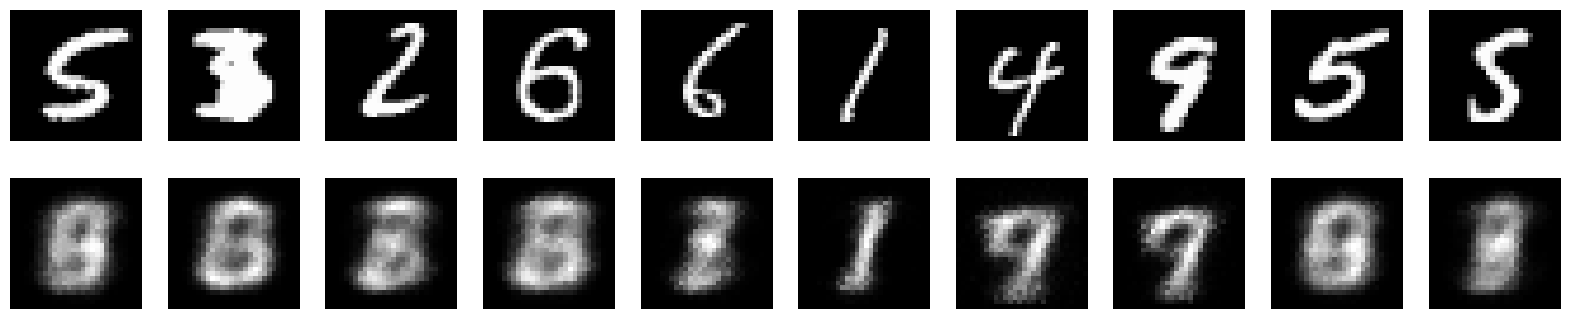

Epoch: 2/27 | Loss: 173.7223969 = Recon: 173.2379150 + KL: 4.8447828: 100%|██████████| 906/906 [00:35<00:00, 25.46it/s]
Epoch: 3/27 | Loss: 163.4160614 = Recon: 162.7850952 + KL: 6.3097105: 100%|██████████| 906/906 [00:34<00:00, 26.15it/s]


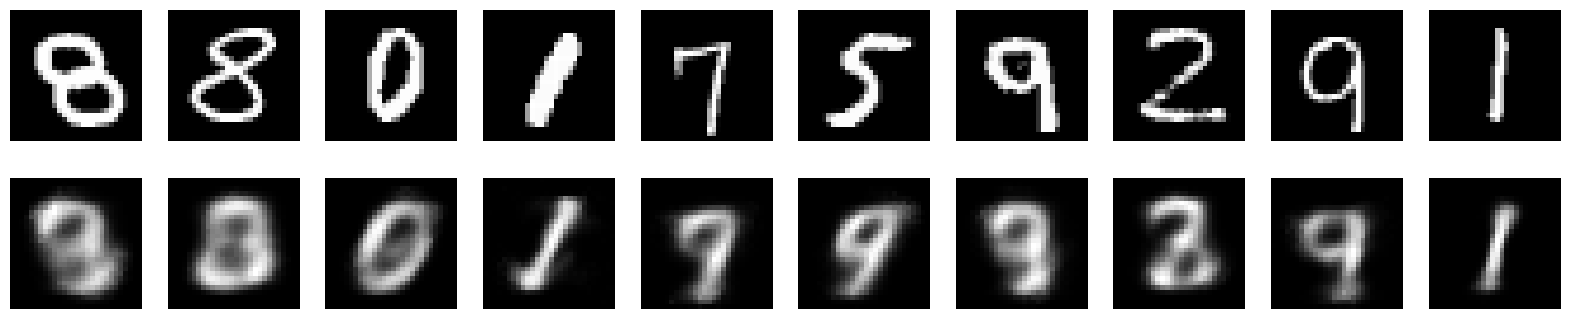

Epoch: 4/27 | Loss: 156.8321381 = Recon: 155.9832916 + KL: 8.4884872: 100%|██████████| 906/906 [00:34<00:00, 26.01it/s]
Epoch: 5/27 | Loss: 161.3544922 = Recon: 160.7818909 + KL: 5.7259698: 100%|██████████| 906/906 [00:34<00:00, 26.29it/s] 


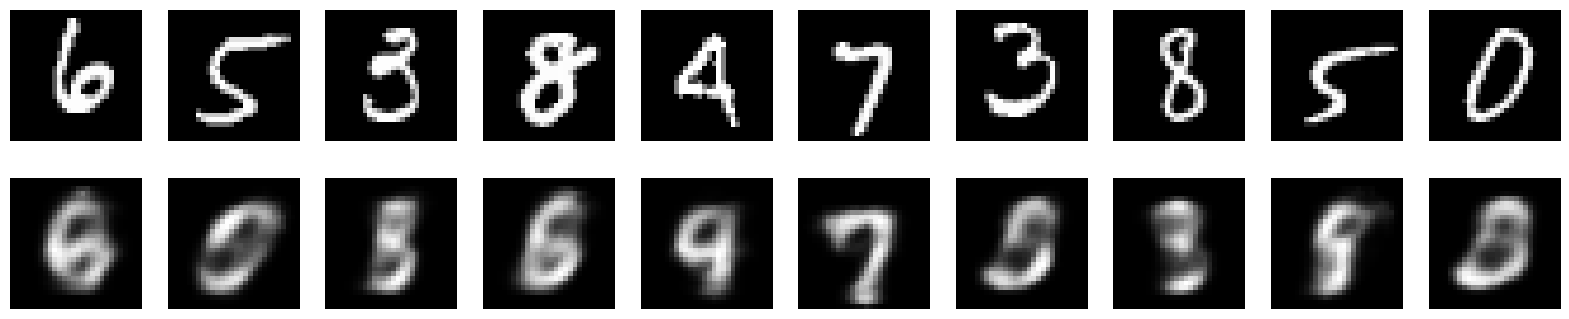

Epoch: 6/27 | Loss: 155.8098602 = Recon: 154.9735565 + KL: 8.3629675: 100%|██████████| 906/906 [00:34<00:00, 26.23it/s]
Epoch: 7/27 | Loss: 153.8521881 = Recon: 153.1675110 + KL: 6.8468060: 100%|██████████| 906/906 [00:34<00:00, 26.36it/s]


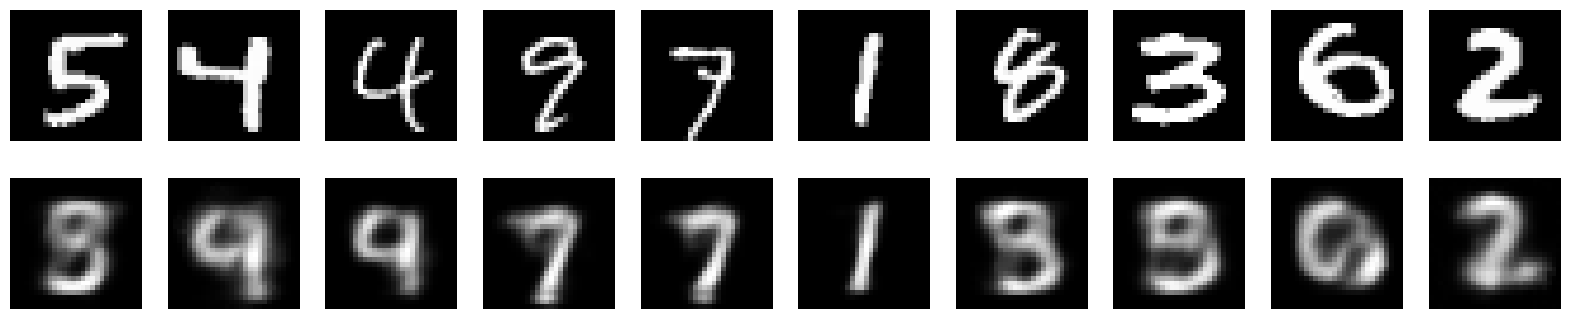

Epoch: 8/27 | Loss: 149.4658661 = Recon: 148.7760315 + KL: 6.8983316: 100%|██████████| 906/906 [00:34<00:00, 26.30it/s]
Epoch: 9/27 | Loss: 154.6850891 = Recon: 153.7728882 + KL: 9.1219683: 100%|██████████| 906/906 [00:34<00:00, 26.33it/s] 


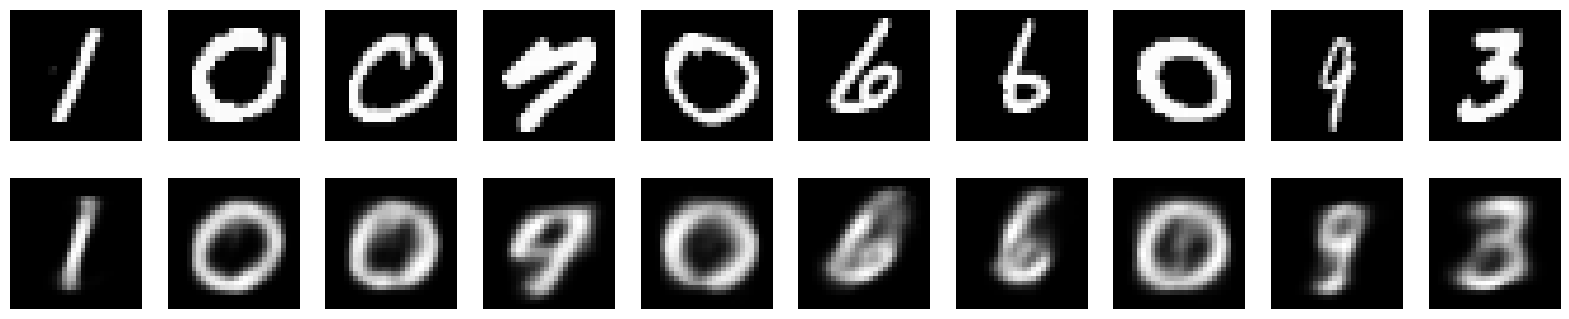

Epoch: 10/27 | Loss: 145.5852661 = Recon: 144.7896881 + KL: 7.9558234: 100%|██████████| 906/906 [00:36<00:00, 24.53it/s] 
Epoch: 11/27 | Loss: 142.7280731 = Recon: 141.7760773 + KL: 9.5198889: 100%|██████████| 906/906 [00:38<00:00, 23.77it/s]


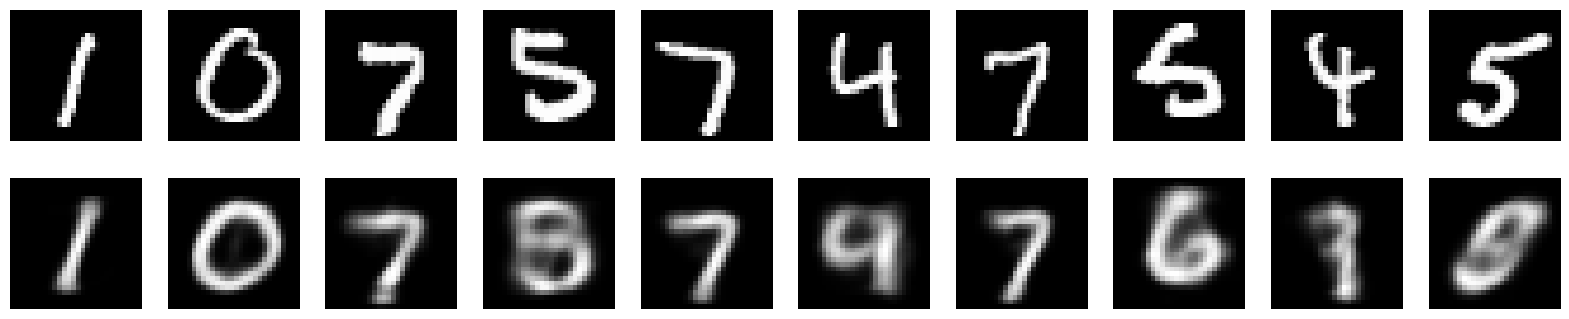

Epoch: 12/27 | Loss: 144.2186584 = Recon: 143.4679565 + KL: 7.5070086: 100%|██████████| 906/906 [00:39<00:00, 23.08it/s]
Epoch: 13/27 | Loss: 154.5632477 = Recon: 153.9134979 + KL: 6.4974809: 100%|██████████| 906/906 [00:34<00:00, 26.18it/s]


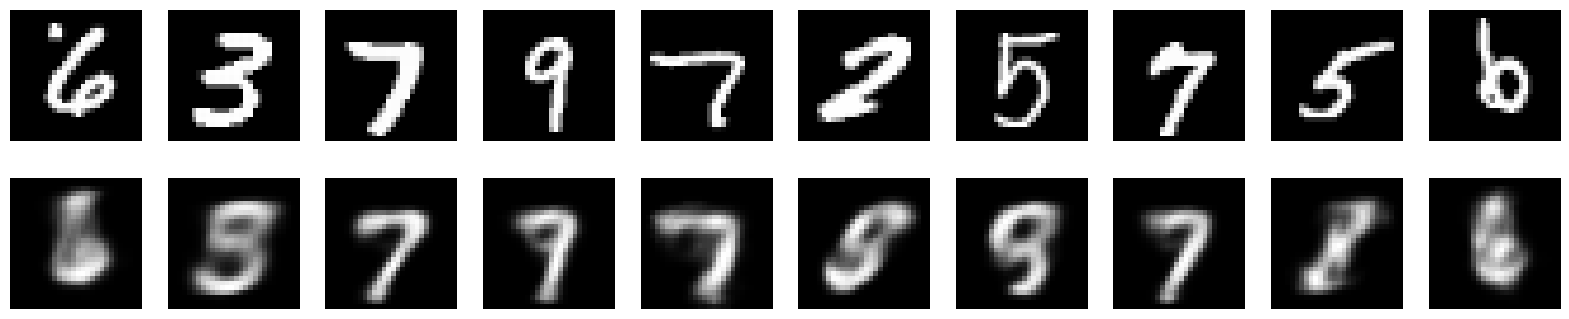

Epoch: 14/27 | Loss: 151.5389557 = Recon: 150.8129120 + KL: 7.2604499: 100%|██████████| 906/906 [00:35<00:00, 25.82it/s]
Epoch: 15/27 | Loss: 155.8026886 = Recon: 155.1321106 + KL: 6.7058234: 100%|██████████| 906/906 [00:34<00:00, 25.93it/s]


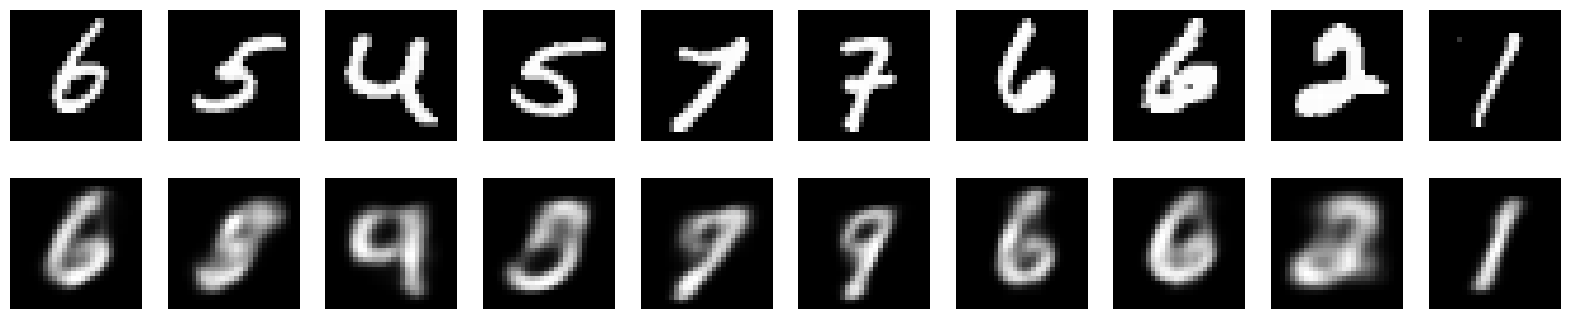

Epoch: 16/27 | Loss: 135.6812134 = Recon: 134.9602509 + KL: 7.2096014: 100%|██████████| 906/906 [00:34<00:00, 25.96it/s]
Epoch: 17/27 | Loss: 146.8629608 = Recon: 146.0668640 + KL: 7.9610019: 100%|██████████| 906/906 [00:32<00:00, 28.17it/s]


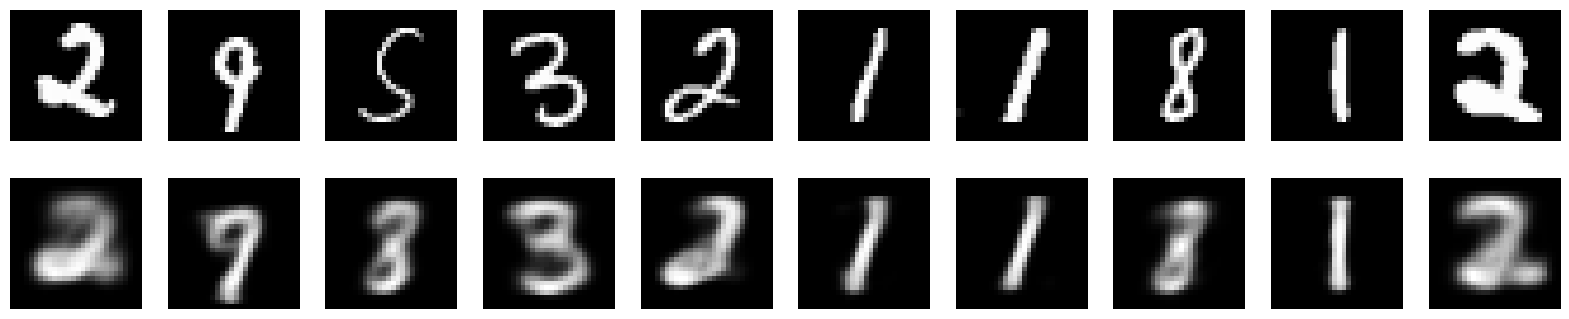

Epoch: 18/27 | Loss: 141.0312042 = Recon: 140.0995026 + KL: 9.3169479: 100%|██████████| 906/906 [00:30<00:00, 30.04it/s]
Epoch: 19/27 | Loss: 168.1851807 = Recon: 167.2861176 + KL: 8.9905691: 100%|██████████| 906/906 [00:30<00:00, 29.61it/s]


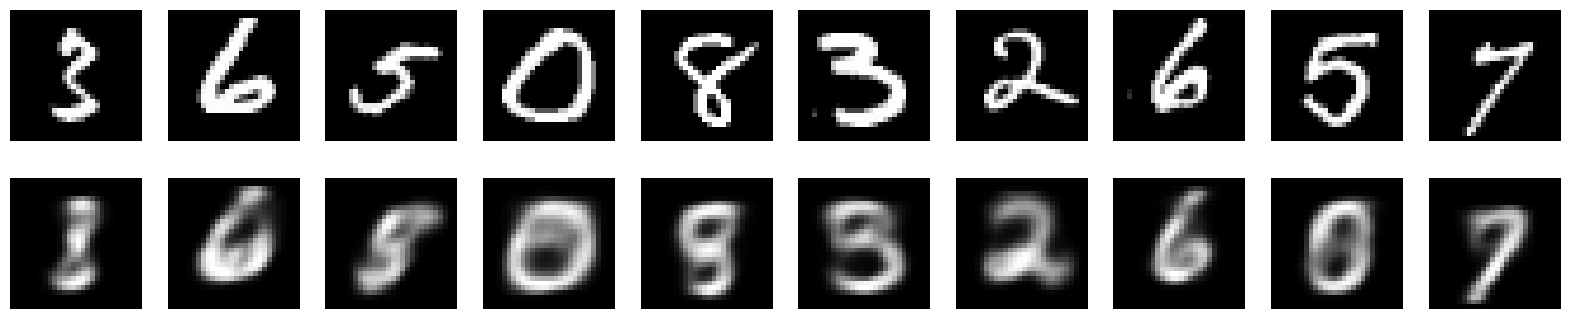

Epoch: 20/27 | Loss: 151.1848907 = Recon: 150.4357758 + KL: 7.4911056: 100%|██████████| 906/906 [00:30<00:00, 29.65it/s]
Epoch: 21/27 | Loss: 152.0466156 = Recon: 151.4037476 + KL: 6.4287491: 100%|██████████| 906/906 [00:30<00:00, 29.69it/s]


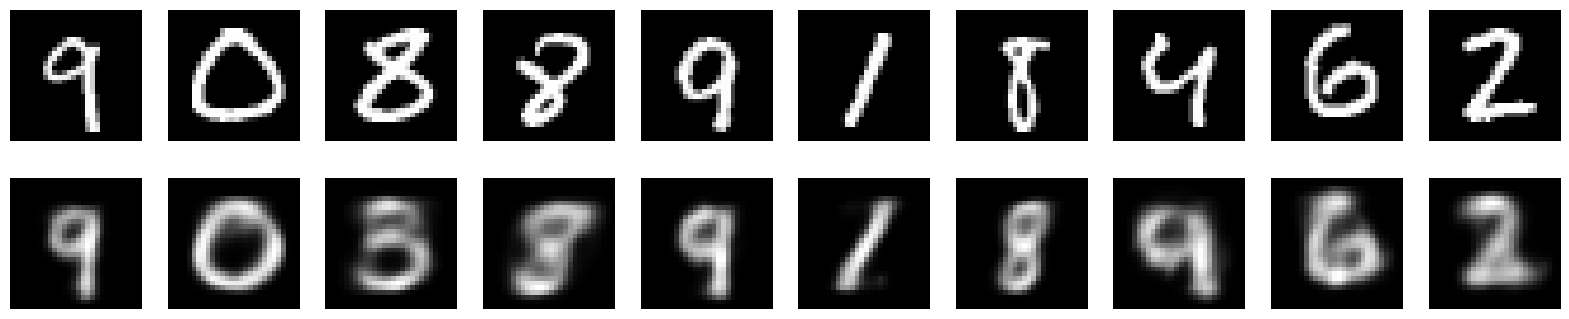

Epoch: 22/27 | Loss: 152.3231506 = Recon: 151.5442657 + KL: 7.7887878: 100%|██████████| 906/906 [00:30<00:00, 30.13it/s]
Epoch: 23/27 | Loss: 163.0655518 = Recon: 162.3490295 + KL: 7.1651998: 100%|██████████| 906/906 [00:30<00:00, 30.08it/s]


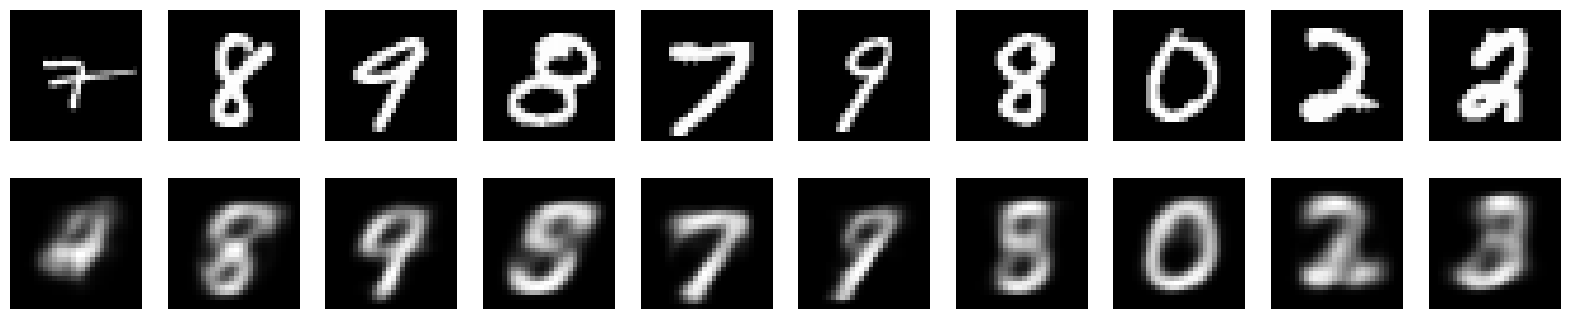

Epoch: 24/27 | Loss: 145.7926178 = Recon: 144.9948425 + KL: 7.9776855: 100%|██████████| 906/906 [00:30<00:00, 29.49it/s]
Epoch: 25/27 | Loss: 143.0777893 = Recon: 142.4486084 + KL: 6.2918706: 100%|██████████| 906/906 [00:31<00:00, 28.37it/s] 


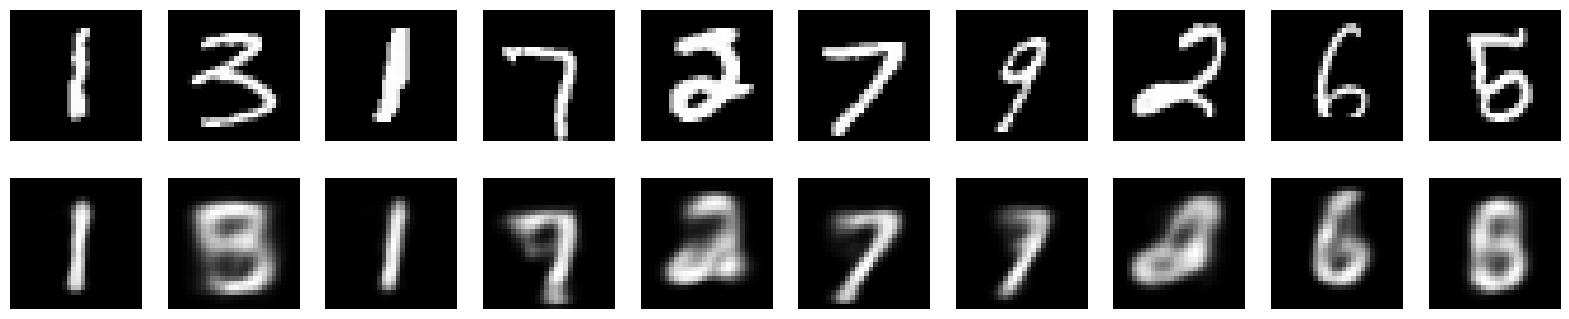

Epoch: 26/27 | Loss: 152.6374054 = Recon: 151.7824707 + KL: 8.5494003: 100%|██████████| 906/906 [00:32<00:00, 27.64it/s]
Epoch: 27/27 | Loss: 138.9500732 = Recon: 138.3507538 + KL: 5.9932318: 100%|██████████| 906/906 [00:36<00:00, 24.72it/s]


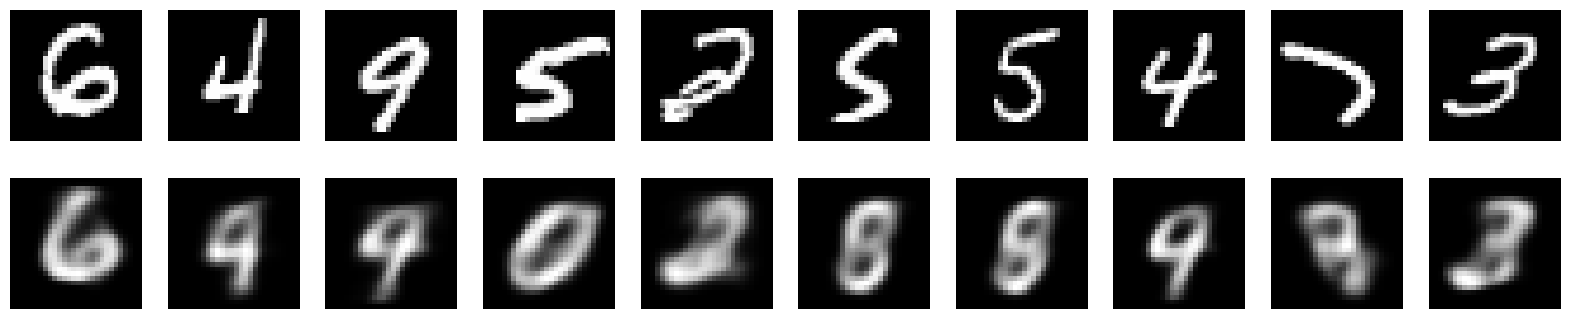

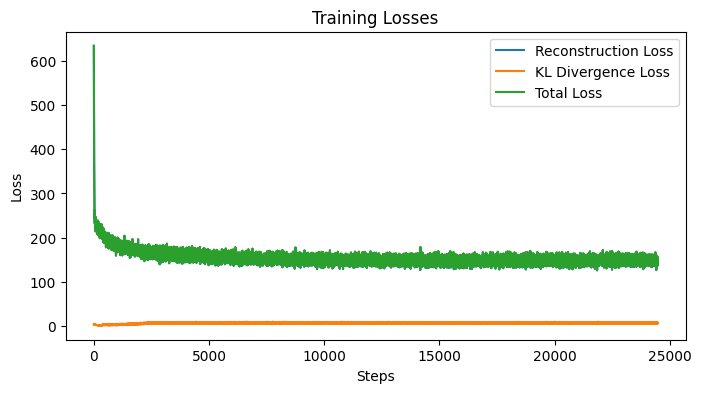

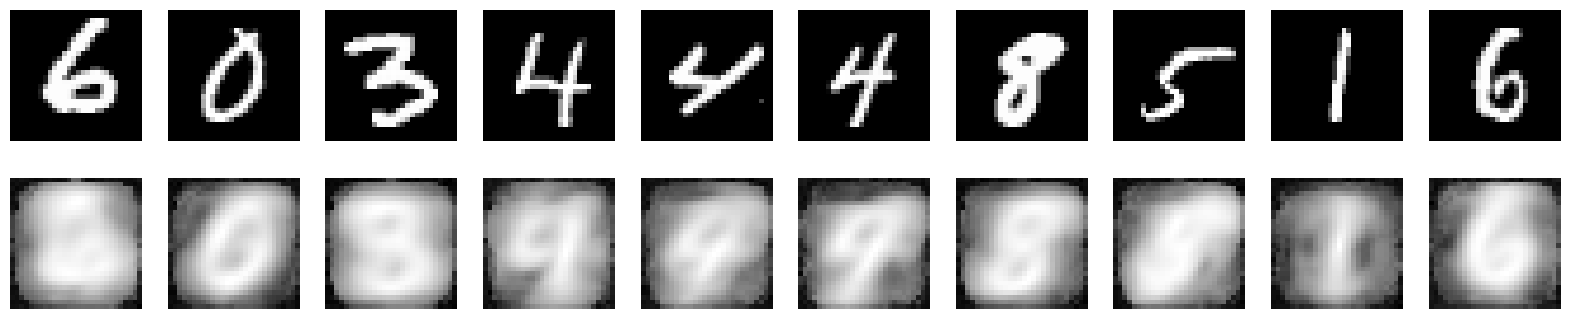

<Figure size 800x400 with 0 Axes>

In [6]:
# Training
from torch.optim import AdamW
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

class TCVAE(nn.Module):
    def __init__(
        self, 
        input_dim, 
        embed_size, 
        heads, 
        num_layers, 
        dropout, 
        forward_expansion, 
        latent_dim,
        num_categories
    ):
        super(TCVAE, self).__init__()
        self.encoder = Encoder(input_dim, embed_size, heads, num_layers, dropout, forward_expansion, latent_dim)
        self.decoder = Decoder(latent_dim, embed_size, heads, num_layers, dropout, forward_expansion, output_dim=input_dim)
        self.num_categories = num_categories
        self.beta = 0.1  # beta-VAE parameter

    def reparameterize(self, logits, temperature=1.0):
        return F.gumbel_softmax(logits, tau=temperature, hard=False, dim=-1)

    # def forward(self, x, mask=None, temperature=1.0):
    #     logits = self.encoder(x, mask)
    #     z = self.reparameterize(logits, temperature)
    #     recon_logits = self.decoder(z, mask)
    #     return recon_logits, logits
    def forward(self, x, mask=None, temperature=1.0):
        mu, log_var = self.encoder(x, mask)
        logits = mu  # Use mu as logits
        z = self.reparameterize(logits, temperature)
        recon_logits = self.decoder(z, mask)
        return recon_logits, logits

    def loss_function(self, x, recon_logits, logits, labels):
        x_normalized = x.float()
        # recon_loss = F.binary_cross_entropy_with_logits(recon_logits, x_normalized, reduction='sum') / x.shape[0]
        recon_loss = F.binary_cross_entropy_with_logits(recon_logits.squeeze(1), x_normalized, reduction='sum') / x.shape[0]

        log_softmax_logits = F.log_softmax(logits, dim=-1)
        # one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels.unsqueeze(1), 1.0)
        # Adjust this part
        one_hot_labels = torch.zeros_like(log_softmax_logits)
        for i in range(one_hot_labels.size(1)):  # For each sequence
            one_hot_labels[:, i, :] = one_hot_labels[:, i, :].scatter_(1, labels.unsqueeze(1), 1.0)
    
        kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum') / x.shape[0]
        
        return recon_loss + self.beta * kl_loss, recon_loss, kl_loss


def train_TCVAE(
    train_dataset,
    epochs=20,
    batch_size=32,
    learning_rate=1e-5,
    embed_size=32,
    heads=2,
    num_layers=2,
    dropout=0.2,
    forward_expansion=2,
    latent_dim=30,
    num_categories=10,
    initial_temperature=2.0,
    final_temperature=0.8
):
    # Load MNIST dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    annealing_rate = (initial_temperature - final_temperature) / (epochs * len(train_loader))

    # Initialize the model and optimizer
    model = TCVAE(
        input_dim=784, 
        embed_size=embed_size, 
        heads=heads, 
        num_layers=num_layers, 
        dropout=dropout, 
        forward_expansion=forward_expansion, 
        latent_dim=latent_dim, 
        num_categories=num_categories
    )
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * epochs, eta_min=1e-5)

    # Move model to appropriate device
    model.to(device)

    # Lists to store losses
    recon_losses = []
    kl_losses = []
    total_losses = []
    inf = float('inf')
    # pbar = tqdm(train_loader, total=len(train_loader)*epochs)
    # Outer loop for epochs
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for data, labels in pbar:
            data, labels = data.view(data.size(0), -1).to(device), labels.to(device)
            optimizer.zero_grad()
            recon_logits, logits = model(data, temperature=initial_temperature)

            # Calculate losses
            total_loss, recon_loss, kl_loss = model.loss_function(data, recon_logits, logits, labels)
            total_loss.backward()

            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(total_loss.item())

            optimizer.step()
            pbar.set_description(f'Epoch: {epoch+1}/{epochs} | Loss: {total_loss.item():.7f} = Recon: {recon_loss.item():.7f} + KL: {kl_loss.item():.7f}')

            scheduler.step()
            initial_temperature -= annealing_rate
            initial_temperature = max(initial_temperature, final_temperature)
        pbar.close()
        if total_loss.item() == inf:
            print("Loss is inf, stopping training")
            return model, total_loss
        
        # 每隔几个epochs或在开始时检查模型的输出
        if epoch % 2 == 0:
            # 选择一批样本
            sample_data, _ = next(iter(train_loader))
            sample_data = sample_data.view(sample_data.size(0), -1).to(device)

            # 获取模型的输出
            with torch.no_grad():
                recon_logits, logits = model(sample_data)
                reconstructed = torch.sigmoid(recon_logits).cpu().numpy()

            # 可视化原始和重构的样本
            fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
            for i in range(10):
                # 原始样本
                axes[0, i].imshow(sample_data[i].cpu().reshape(28, 28), cmap='gray')
                axes[0, i].axis('off')
                
                # 重构的样本
                axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
                axes[1, i].axis('off')
            
            plt.show()

    # Plot the losses
    plt.figure(figsize=(8, 4))
    plt.plot(recon_losses, label="Reconstruction Loss")
    plt.plot(kl_losses, label="KL Divergence Loss")
    plt.plot(total_losses, label="Total Loss")
    plt.title("Training Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # 选择一批样本
    sample_data, _ = next(iter(train_loader))
    sample_data = sample_data.view(sample_data.size(0), -1).to(device)

    # 获取模型的输出
    with torch.no_grad():
        rocon_x, _ = model(sample_data)

    # 可视化原始和重构的样本
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    for i in range(10):
        # 原始样本
        axes[0, i].imshow(sample_data[i].cpu().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')

        # 重构的样本
        axes[1, i].imshow(rocon_x[i].cpu().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.figure(figsize=(8, 4))
    plt.show()

    return model, total_loss

# # Train the modified TCVAE
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Split the dataset into training and validation sets
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
model = train_TCVAE(learning_rate=0.0004667, 
              embed_size=256,
              heads=32,
              num_layers=1,
              dropout=0.6747343,
              forward_expansion=1,
              latent_dim=29,
              batch_size=53,
              epochs=27,
              train_dataset=train_dataset)


In [7]:
# import optuna

# # Split the dataset into training and validation sets
# transform = transforms.Compose([transforms.ToTensor()])
# full_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
# train_size = int(0.8 * len(full_dataset))
# val_size = len(full_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# def get_divisors(n):
#     divisors = [i for i in range(1, n + 1) if n % i == 0]
#     return divisors

# def get_possible_heads_for_embed_size_range(min_embed_size, max_embed_size):
#     # Getting divisors for the maximum value in the range.
#     all_divisors = get_divisors(max_embed_size)
    
#     # Filter out divisors that are smaller than the minimum embed size.
#     valid_divisors = [div for div in all_divisors if div >= min_embed_size]
    
#     return valid_divisors

# def objective(trial):
#     # Propose hyperparameters using a trial object
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
#     embed_size = trial.suggest_categorical('embed_size', [16, 32, 64, 128, 256])
#     divisors_of_embed_size = get_possible_heads_for_embed_size_range(16, 256)
#     heads = trial.suggest_categorical('heads', divisors_of_embed_size)
#     num_layers = trial.suggest_int("num_layers", 1, 4)
#     dropout = trial.suggest_float("dropout", 0.1, 0.9)
#     forward_expansion = trial.suggest_int("forward_expansion", 1, 4)
#     latent_dim = trial.suggest_int("latent_dim", 10, 50)
#     batch_size = trial.suggest_int("batch_size", 16, 128)
#     epochs = trial.suggest_int("epochs", 10, 50)

#     # Train your model using the proposed hyperparameters
#     model,_ = train_TCVAE(
#         train_dataset=train_dataset,
#         epochs=epochs,
#         batch_size=batch_size,
#         learning_rate=learning_rate,
#         embed_size=embed_size,
#         heads=heads,
#         num_layers=num_layers,
#         dropout=dropout,
#         forward_expansion=forward_expansion,
#         latent_dim=latent_dim
#     )

#     # Evaluate the model on the validation set
#     model.eval()
#     validation_losses = []
#     with torch.no_grad():
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#         for data, labels in val_loader:
#             data, labels = data.view(data.size(0), -1).to(device), labels.to(device)
#             recon_logits, logits = model(data)
#             total_loss, _, _ = model.loss_function(data, recon_logits, logits, labels)
#             validation_losses.append(total_loss.item())
#     validation_loss = sum(validation_losses) / len(validation_losses)

#     # Log the trial results
#     with open("logs.txt", "a") as log_file:
#         log_file.write(f"Trial {trial.number}, Validation Loss: {validation_loss}\n")
#         for key, value in trial.params.items():
#             log_file.write(f"    {key}: {value}\n")
#         log_file.write("\n")

#     print(f"Trial {trial.number}, Validation Loss: {validation_loss}")
#     return validation_loss


# # Create a study object and specify the direction is "minimize".
# study = optuna.create_study(direction="minimize")

# # Optimize the study, the objective function is passed in as the first argument.
# study.optimize(objective, n_trials=50)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial

# print("Value: ", trial.value)
# print("Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
